# Population Estimates: Compute confidence levels for all parcels

In [28]:
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [29]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [30]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')

BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [31]:
# Define parameters
# * Percentage of samples in each income strata to process
percentage_of_samples = 0.03

# * Divide compute ----- MODIFY AGENT HERE (N Nathan, A Andrea) ---------
agent = 'A'

# Note: These parameters are relevant for how OSM footprints are used
# to identify the main building and to decide whether to snap to OSM small building 
# footprints. 
# The limit_2016_inferences parameter determines whether OSM footprints are used 
# symmetrically for 2020 and 2016. If True, we only include OSM footprints for 2016
# if these have been partially discovered by model inferences. If False, we include
# any OSM small building for the 2016 footprints (as done for 2020).

model_params = {'area_threshold_main': 30, 'area_threshold_small': 20,
                'flatten_threshold': 0.85, 'main_expansion_type': 'raw_polygons', 
                'main_polygon_definition': 'OSM', 'negative_buffer': 0.5, 'simplify_tolerance': 0,
                'limit_2016_inferences': True}

# 1. Compute confidences

In [32]:
def main():
    # Load data
    # * Residential parcels (assigned to CBGs)
    sj_parcels_res = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))
    assert sj_parcels_res.duplicated('APN').sum() == 0

    # * Census block groups
    cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

    # * Permits
    sj_parcel_permit = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_found.csv'))
    sj_permit_noparcel = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_notfound.csv'))
    sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
    sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])
    
    # Add income strata information to parcel data
    sj_parcels_res = pd.merge(
        sj_parcels_res, cbg_income_2016_SJ[['GEOID', 'strata_inc']], 
        how='left', validate='many_to_one')
    
    # Divide compute (split up the income strata)
    unique_strata = sj_parcels_res['strata_inc'].unique()

    # Find a seed that balances the number of APNs 
    np.random.seed(44)
    a1_strata = np.random.choice(unique_strata, size=len(unique_strata)//2, replace=False)

    sj_parcels_res['agent'] = sj_parcels_res['strata_inc'].apply(
        lambda strata_inc: 'A' if strata_inc in a1_strata else 'N')
    
    # Drop parcels for other agent
    sj_parcels_res = sj_parcels_res.loc[sj_parcels_res['agent'] == agent]
    
    # Set up output files
    parcel_output = os.path.join(OUTPUT_FP, 'Confidences', agent, 'parcel-confidence.csv')
    building_output = os.path.join(OUTPUT_FP, 'Confidences', agent, 'building-confidence-{}')

    if os.path.exists(parcel_output):
        parcel_conf_df = pd.read_csv(parcel_output)
        buildings_gpd = {'2016': gpd.read_file(building_output.format('2016')), 
                     '2020': gpd.read_file(building_output.format('2020'))}

        reviewed_parcels = parcel_conf_df['APN'].unique()
        reviewed_istrata = parcel_conf_df['strata_inc'].unique()

        print('[INFO] Number of reviewed income strata: {}'.format(len(reviewed_istrata)))
        print('[INFO] Number of reviewed parcels: {}'.format(len(reviewed_parcels)))

    else:
        os.makedirs(os.path.dirname(parcel_output))

        parcel_conf_df = pd.DataFrame()
        buildings_gpd = {'2016': gpd.GeoDataFrame(geometry=[]), '2020': gpd.GeoDataFrame(geometry=[])}
        reviewed_parcels = []
        
    # Compute confidence for each parcel, order by income strata
    for strata_inc in tqdm(sj_parcels_res['strata_inc'].unique()):
        parcels_to_review = sj_parcels_res.loc[sj_parcels_res['strata_inc'] == strata_inc]['APN'].unique()

        # Sample parcels
        np.random.seed(42)
        strata_inc_N = len(parcels_to_review)
        parcels_to_review = np.random.choice(
            parcels_to_review, size=int(strata_inc_N * percentage_of_samples), replace=False)

        for i, parcel_apn in enumerate(parcels_to_review):
            if parcel_apn in reviewed_parcels:
                continue

            # Compute confidence
            parcel_conf, parcel_build = parcel_confidence(
                sj_parcels_res, sj_parcel_permit, parcel_apn, model_params)

            # Get geoid
            parcel_geoid = sj_parcels_res.loc[sj_parcels_res['APN'] == parcel_apn].iloc[0]['GEOID']

            # Append
            parcel_conf_df = pd.concat([parcel_conf_df, pd.DataFrame.from_dict(
                {'APN': [parcel_apn], 'GEOID': [parcel_geoid],
                 'strata_inc': [strata_inc], 'confidence': [parcel_conf]})])

            for year in ['2016', '2020']:
                if parcel_build[year] is not None:
                    parcel_build[year]['APN'] = parcel_apn
                    buildings_gpd[year] = pd.concat([buildings_gpd[year], parcel_build[year]])

            if i % 50 == 0 or i == len(parcels_to_review):
                parcel_conf_df.to_csv(parcel_output, index=False)
                for year in ['2016', '2020']:
                    buildings_gpd[year].to_file(building_output.format(year))

In [ ]:
main()

# 2. Output checks

In [35]:
parcel_output = os.path.join(OUTPUT_FP, 'Confidences', agent, 'parcel-confidence.csv')
building_output = os.path.join(OUTPUT_FP, 'Confidences', agent, 'building-confidence-{}')

parcel_conf_df = pd.read_csv(parcel_output)
buildings_gpd = {
    '2016': gpd.read_file(building_output.format('2016')), 
    '2020': gpd.read_file(building_output.format('2020'))}

reviewed_parcels = parcel_conf_df['APN'].unique()
reviewed_istrata = parcel_conf_df['strata_inc'].unique()

print('[INFO] Number of reviewed income strata: {}'.format(len(reviewed_istrata)))
print('[INFO] Number of reviewed parcels: {}'.format(len(reviewed_parcels)))

[INFO] Number of reviewed income strata: 1
[INFO] Number of reviewed parcels: 151


In [36]:
# Load data
parcel_conf_df.head()

,APN,GEOID,strata_inc,confidence
0,44226032,60855029022,IS_40,NaN
1,44723136,60855029071,IS_40,NaN
2,44247031,60855029022,IS_40,NaN
3,46750043,60855013002,IS_40,0.705881
4,44229002,60855029022,IS_40,NaN


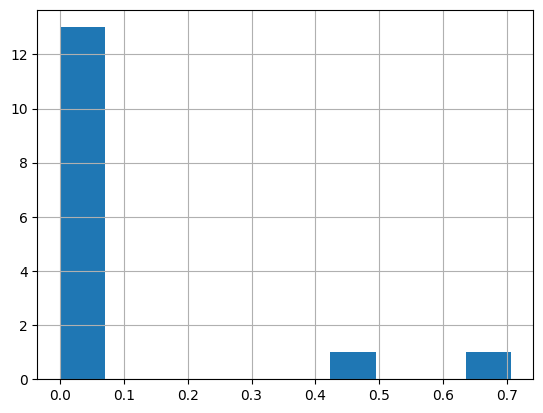

In [19]:
parcel_conf_df['confidence'].hist()
plt.show()

In [20]:
buildings_gpd['2020']['build_conf'] = buildings_gpd['2020']['build_conf'].astype('float')

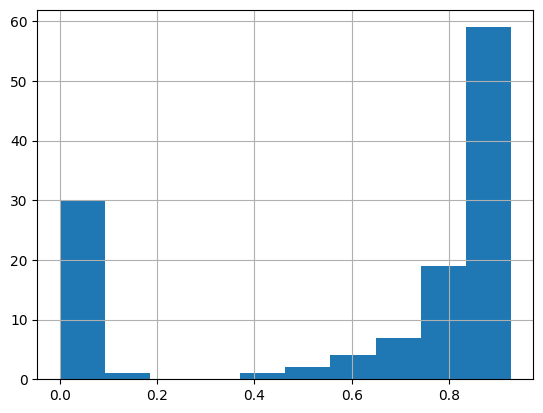

In [21]:
buildings_gpd['2020']['build_conf'].hist()
plt.show()